In [1]:
!pip install -q transformers pandas openpyxl scikit-learn matplotlib seaborn tqdm pyarrow

In [ ]:
import os, json
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
from sklearn.decomposition import PCA

import torch
from transformers import BertTokenizer, BertModel
from google.colab import files

sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.dpi"] = 120

In [ ]:
print("📤 COS_verbs_2893.xlsx 파일을 업로드하세요…")
uploaded = files.upload()
fname = list(uploaded.keys())[0]
print("Loaded:", fname)

df = pd.read_excel(fname)

📤 COS_verbs_2893.xlsx 파일을 업로드하세요…


Saving COS_verbs_2893.xlsx to COS_verbs_2893 (1).xlsx
Loaded: COS_verbs_2893 (1).xlsx


In [ ]:
df.columns = [c.strip() for c in df.columns]

def pick(*names):
    """가능한 여러 후보 중 첫 번째 존재하는 컬럼명을 반환(소문자 비교)."""
    lower = {c.lower(): c for c in df.columns}
    for n in names:
        if n.lower() in lower:
            return lower[n.lower()]
    return None

COL_SENT = pick("sentence","sent","text", "Instance")
COL_VERB = pick("verb","lemma","verb (lemma)")
COL_SYN  = pick("realization","syntax","construction","syn")
COL_INT  = pick("intentionality","intent","causer_intentionality")
COL_ID   = pick("identifiability","id","causer_identifiability", "C.Identifiability")

need = [COL_SENT, COL_VERB, COL_SYN, COL_INT, COL_ID]
if any(x is None for x in need):
    raise ValueError(f"필수 컬럼을 찾지 못했습니다. 찾은 값 => "
                     f"sentence:{COL_SENT}, verb:{COL_VERB}, syntax:{COL_SYN}, "
                     f"intentionality:{COL_INT}, identifiability:{COL_ID}")

In [ ]:
df = df[[COL_SENT, COL_VERB, COL_SYN, COL_INT, COL_ID]].copy()
df.rename(columns={
    COL_SENT:"sentence",
    COL_VERB:"verb",
    COL_SYN :"syntax",
    COL_INT :"intentionality",
    COL_ID  :"identifiability"
}, inplace=True)

In [ ]:
df["sentence"] = df["sentence"].astype(str).str.strip()
df["verb"] = df["verb"].astype(str).str.strip()

# syntax: "Caus"/"NCaus"로 통일
df["syntax"] = df["syntax"].astype(str).str.strip()
df["syntax"] = df["syntax"].replace({
    "Causative":"Caus", "NCausative":"NCaus",
    "causative":"Caus", "noncausative":"NCaus",
    "CAUS":"Caus", "NCAUS":"NCaus"
})
# intentionality: "Intent"/"NIntent"로 통일 (혹시 Agent/Int_act 등을 Intent로 간주하고 싶으면 여기서 매핑)
df["intentionality"] = df["intentionality"].astype(str).str.strip()
df["intentionality"] = df["intentionality"].replace({
    "Intentional":"Intent", "Nonintentional":"NIntent",
    "intentional":"Intent", "nonintentional":"NIntent",
    "Agent":"Intent", "Int_act":"Intent",
    "Cause_inan":"NIntent", "Cause_anim":"NIntent"
})
# identifiability: Spec / RC / UC 로 통일
df["identifiability"] = df["identifiability"].astype(str).str.strip()
df["identifiability"] = df["identifiability"].replace({
    "Specified":"Spec", "specified":"Spec", "SPEC":"Spec",
    "Recoverable":"RC", "recoverable":"RC", "RC_default":"RC",
    "RC_mentioned":"RC", "RC_other":"RC", "RC_hinted":"RC",
    "Unknown":"UC", "unknown":"UC"
})

print(df.head())

                                            sentence   verb syntax  \
0  That fear did not abate when , briefly , he ha...  abate  NCaus   
1  After the achievement of political independenc...  abate  NCaus   
2  The number of unemployed demonstrations did no...  abate  NCaus   
3  The deluge still had n't abated when Maggie dr...  abate  NCaus   
4  Before 1914 , neither peasant land hunger nor ...  abate  NCaus   

  intentionality identifiability  
0        NIntent              RC  
1        NIntent              RC  
2        NIntent              RC  
3        NIntent              RC  
4        NIntent              RC  


In [ ]:
device = torch.device("cpu")
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", use_fast=True)
model = BertModel.from_pretrained("bert-base-uncased").to(device)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
def find_span(sentence, lemma):
    enc = tokenizer(sentence, return_offsets_mapping=True, return_tensors="pt")
    toks = tokenizer.convert_ids_to_tokens(enc["input_ids"][0])
    # [CLS]와 [SEP] 제외한 내부 토큰 인덱스 기반으로 조합
    core = toks[1:-1]
    # de-wordpiece 하면서 span 기록
    spans = []
    i = 0
    while i < len(core):
        if core[i].startswith("##"):
            i += 1; continue
        j = i+1
        w = core[i]
        while j < len(core) and core[j].startswith("##"):
            w += core[j][2:]
            j += 1
        # +1: [CLS] 보정
        spans.append((w.lower(), (i+1, j)))
        i = j
    lem = str(lemma).lower()
    # 정확 일치 우선, 없으면 startswith
    for w,(a,b) in spans:
        if w == lem: return (a,b)
    for w,(a,b) in spans:
        if w.startswith(lem): return (a,b)
    return None

@torch.no_grad()
def embed_at_lemma(sentence, lemma):
    enc = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)
    out = model(**{k:v.to(device) for k,v in enc.items()})
    last = out.last_hidden_state  # [1, T, 768]
    T = last.shape[1]
    span = find_span(sentence, lemma)
    if span is None:
        # fallback: [CLS]
        return last[:,0,:].squeeze(0).cpu().numpy(), {"strategy":"CLS","span":None}
    a,b = span
    a = max(1, min(a, T-1)); b = max(1, min(b, T-1))
    vec = last[:, a:b, :].mean(dim=1).squeeze(0).cpu().numpy()
    return vec, {"strategy":"lemma_span_mean","span":(int(a),int(b))}

In [ ]:
embeds, meta = [], []
# Drop rows with NaN in 'sentence' or 'verb' before generating embeddings
df_cleaned = df.dropna(subset=["sentence", "verb"]).copy()

for _, r in tqdm(df_cleaned.iterrows(), total=len(df_cleaned), desc="Embedding"):
    v, info = embed_at_lemma(r["sentence"], r["verb"])
    embeds.append(v); meta.append(info)
E = np.vstack(embeds)
df["embed_strategy"] = [m["strategy"] for m in meta]
df["embed_span"]     = [json.dumps(m["span"]) for m in meta]

# 저장
os.makedirs("outputs", exist_ok=True)
np.save("outputs/COS_embeddings.npy", E)
print("Saved: outputs/COS_embeddings.npy")

Embedding: 100%|██████████| 2893/2893 [08:21<00:00,  5.77it/s]

Saved: outputs/COS_embeddings.npy


In [ ]:
# Ensure E is a pandas DataFrame to easily handle NaNs and keep track of indices
E_df = pd.DataFrame(E)

# Identify rows with NaNs in the embeddings
nan_rows_in_E = E_df.isnull().any(axis=1)

# Filter out rows with NaNs from both the embeddings and the cleaned dataframe used for embeddings
# Use the index from the original df_cleaned to align E_df
valid_indices = df_cleaned[~nan_rows_in_E].index

E_cleaned = E_df[~nan_rows_in_E].values
df_aligned = df_cleaned[~nan_rows_in_E].copy() # Use df_cleaned which was used for embedding generation

pca = PCA(n_components=2, random_state=42)
PC = pca.fit_transform(E_cleaned)
print("Explained variance:", pca.explained_variance_ratio_)

# Add PCA results directly to the aligned dataframe
df_aligned["PC1"] = PC[:, 0]
df_aligned["PC2"] = PC[:, 1]

# Merge the PCA results back into the original dataframe 'df' based on the index
# Create new PC1 and PC2 columns in df and fill with NaNs initially
df["PC1"] = np.nan
df["PC2"] = np.nan

# Update the original dataframe 'df' with the PC1 and PC2 values from df_aligned using the index
df.loc[df_aligned.index, ["PC1", "PC2"]] = df_aligned[["PC1", "PC2"]]


# 결과 CSV 저장 (요구된 메타 포함)
cols_out = ["verb","syntax","intentionality","identifiability","sentence",
            "embed_strategy","embed_span","PC1","PC2"]
# Select only the columns that exist in the dataframe before saving
cols_out_existing = [col for col in cols_out if col in df.columns]
df[cols_out_existing].to_csv("outputs/COS_embeddings_PCA.csv", index=False)
print("Saved: outputs/COS_embeddings_PCA.csv")

Explained variance: [0.3385497  0.03591635]
Saved: outputs/COS_embeddings_PCA.csv


## Analyze Verbs by PC1 and PC2 Regions

### Subtask:
Divide the PCA space (PC1 and PC2 axes) into regions for Causative and Non-Causative examples and identify the most frequent verbs in each region.

**Reasoning**:
Filter the dataframe for Causative and Non-Causative examples. Define thresholds for left, center, and right regions based on PC1 distribution (tertiles) and top, center, and bottom regions based on PC2 distribution (tertiles) within each syntax category. Filter the data points falling into each of the 3x3 regions and analyze the verb distribution in each subset. Print the most frequent verbs for each region combination to understand the spatial distribution of verbs in the PCA space.

In [ ]:
# Filter data for Causative and Non-Causative examples (reusing cleaned data from previous step)
# df_caus_cleaned and df_nc_cleaned are assumed to be available from the previous analysis cell

# Filter data for Causative and Non-Causative examples
mask_caus = (df["syntax"] == "Caus")
mask_nc   = (df["syntax"] == "NCaus")

df_caus = df[mask_caus].copy()
df_nc   = df[mask_nc].copy()

# Remove rows with NaN in PC1 or PC2 before calculating quantiles
df_caus_cleaned = df_caus.dropna(subset=["PC1", "PC2"]).copy()
df_nc_cleaned = df_nc.dropna(subset=["PC1", "PC2"]).copy()


# Define thresholds for PC1 and PC2 regions (tertiles)
def define_regions(df_cleaned):
    if len(df_cleaned) < 3: # Need at least 3 points to calculate tertiles
         return None, None, None, None, None, None, False

    pc1_left_threshold = df_cleaned["PC1"].quantile(1/3)
    pc1_right_threshold = df_cleaned["PC1"].quantile(2/3)
    pc2_bottom_threshold = df_cleaned["PC2"].quantile(1/3)
    pc2_top_threshold = df_cleaned["PC2"].quantile(2/3)
    return pc1_left_threshold, pc1_right_threshold, pc2_bottom_threshold, pc2_top_threshold, True

pc1_caus_left_thresh, pc1_caus_right_thresh, pc2_caus_bottom_thresh, pc2_caus_top_thresh, caus_enough_data = define_regions(df_caus_cleaned)
pc1_nc_left_thresh, pc1_nc_right_thresh, pc2_nc_bottom_thresh, pc2_nc_top_thresh, nc_enough_data = define_regions(df_nc_cleaned)


# Analyze and print verbs in each region
print("Analyzing Verb Distribution by PC1 and PC2 Regions:")

# Causative Examples
print("\n--- Causative Examples ---")
if caus_enough_data:
    for pc1_region, pc1_label in [(lambda x: x <= pc1_caus_left_thresh, "Left"),
                                  (lambda x: (x > pc1_caus_left_thresh) & (x <= pc1_caus_right_thresh), "Center"),
                                  (lambda x: x > pc1_caus_right_thresh, "Right")]:
        for pc2_region, pc2_label in [(lambda y: y >= pc2_caus_top_thresh, "Top"),
                                      (lambda y: (y < pc2_caus_top_thresh) & (y > pc2_caus_bottom_thresh), "Center"),
                                      (lambda y: y <= pc2_caus_bottom_thresh, "Bottom")]:

            # Filter data for the current region
            region_mask = pc1_region(df_caus_cleaned["PC1"]) & pc2_region(df_caus_cleaned["PC2"])
            df_region = df_caus_cleaned[region_mask].copy()

            print(f"\n  Causative (PC1: {pc1_label}, PC2: {pc2_label}) - {len(df_region)} points:")
            if len(df_region) > 0:
                print(df_region["verb"].value_counts().head(5)) # Display top 5 verbs
            else:
                print("    No data points in this region.")
else:
    print("  Not enough data points in Causative examples for region analysis.")


# Non-Causative Examples
print("\n--- Non-Causative Examples ---")
if nc_enough_data:
    for pc1_region, pc1_label in [(lambda x: x <= pc1_nc_left_thresh, "Left"),
                                  (lambda x: (x > pc1_nc_left_thresh) & (x <= pc1_nc_right_thresh), "Center"),
                                  (lambda x: x > pc1_nc_right_thresh, "Right")]:
        for pc2_region, pc2_label in [(lambda y: y >= pc2_nc_top_thresh, "Top"),
                                      (lambda y: (y < pc2_nc_top_thresh) & (y > pc2_nc_bottom_thresh), "Center"),
                                      (lambda y: y <= pc2_nc_bottom_thresh, "Bottom")]:

            # Filter data for the current region
            region_mask = pc1_region(df_nc_cleaned["PC1"]) & pc2_region(df_nc_cleaned["PC2"])
            df_region = df_nc_cleaned[region_mask].copy()

            print(f"\n  Non-Causative (PC1: {pc1_label}, PC2: {pc2_label}) - {len(df_region)} points:")
            if len(df_region) > 0:
                print(df_region["verb"].value_counts().head(5)) # Display top 5 verbs
            else:
                print("    No data points in this region.")
else:
    print("  Not enough data points in Non-Causative examples for region analysis.")

Analyzing Verb Distribution by PC1 and PC2 Regions:

--- Causative Examples ---

  Causative (PC1: Left, PC2: Top) - 6 points:
verb
close       1
empty       1
freeze      1
multiply    1
sear        1
Name: count, dtype: int64

  Causative (PC1: Left, PC2: Center) - 62 points:
verb
light       17
empty       11
break        8
sink         4
multiply     4
Name: count, dtype: int64

  Causative (PC1: Left, PC2: Bottom) - 41 points:
verb
break    10
light     7
empty     6
dirty     3
close     2
Name: count, dtype: int64

  Causative (PC1: Center, PC2: Top) - 25 points:
verb
reopen      5
sear        3
sprout      3
rekindle    3
compress    2
Name: count, dtype: int64

  Causative (PC1: Center, PC2: Center) - 33 points:
verb
loose    5
alter    4
loop     4
tame     3
chip     2
Name: count, dtype: int64

  Causative (PC1: Center, PC2: Bottom) - 51 points:
verb
dim      9
sour     8
level    5
dull     5
blunt    4
Name: count, dtype: int64

  Causative (PC1: Right, PC2: Top) - 79 poi

## Regional Verb Distribution Analysis: Purpose and Procedure

### Purpose:

The primary purpose of the regional verb distribution analysis within the BERT-based PCA space of COS verbs is to gain a conceptual understanding of the distributional characteristics of these verb embeddings and to interpret the key semantic dimensions captured by the two principal components (PC1 and PC2). By examining which verbs cluster together in different regions of the PCA space, we aim to identify potential semantic groupings or tendencies associated with the verbs based on their contextual usage as represented by the BERT embeddings. This analysis complements the quantitative MANOVA results by providing a qualitative insight into the semantic landscape of the verbs and how linguistic features like intentionality and identifiability might relate to these spatial distributions.

### Procedure:

The regional verb distribution analysis was conducted through the following steps:

1.  **Data Preparation**: The dataframe containing the PCA results (PC1 and PC2 values) along with the verb, syntax, intentionality, and identifiability information was used. Data points with missing PC1 or PC2 values were excluded from this analysis.
2.  **Data Filtering by Syntax**: The cleaned data was filtered into two subsets based on the 'syntax' column: Causative ('Caus') and Non-Causative ('NCaus') examples.
3.  **Defining Regional Boundaries**: For both the Causative and Non-Causative subsets, the PCA space was divided into a 3x3 grid of regions based on the distribution of data points along the PC1 and PC2 axes. The boundaries for these regions were defined using the tertiles (1/3 and 2/3 quantiles) of the PC1 and PC2 values within each syntax subset. This created three regions along the PC1 axis (Left, Center, Right) and three regions along the PC2 axis (Bottom, Center, Top).
4.  **Identifying Verbs in Each Region**: For each of the resulting nine regions (3 PC1 regions x 3 PC2 regions) within both the Causative and Non-Causative subsets, the data points falling into that specific region were identified.
5.  **Analyzing Verb Frequency**: Within each of the identified regions, the frequency of each unique verb was counted.
6.  **Identifying Top Verbs**: The top 5 most frequent verbs for each region were identified and listed, along with their counts within that region.
7.  **Generating Regional Plots**: Scatter plots of the PCA space were generated for both Causative and Non-Causative examples, with the defined PC1 and PC2 region boundaries visually marked to illustrate the spatial division.
8.  **Conceptual Interpretation**: Based on the distribution of verbs across the regions and the visual patterns in the PCA plots, a conceptual interpretation of what the PC1 and PC2 dimensions might represent semantically or contextually for causative and non-causative verbs was developed. This involved observing which types of verbs or which linguistic features tended to align with higher or lower values on each principal component.

This procedure allowed for a detailed exploration of the PCA space, highlighting areas where specific verbs or groups of verbs tend to cluster, and providing a basis for understanding the semantic distinctions captured by the principal components.

## Regional Verb Distribution Analysis: Purpose and Procedure

### Purpose:

The primary purpose of the regional verb distribution analysis within the BERT-based PCA space of COS verbs is to gain a conceptual understanding of the distributional characteristics of these verb embeddings and to interpret the key semantic dimensions captured by the two principal components (PC1 and PC2). By examining which verbs cluster together in different regions of the PCA space, we aim to identify potential semantic groupings or tendencies associated with the verbs based on their contextual usage as represented by the BERT embeddings. This analysis complements the quantitative MANOVA results by providing a qualitative insight into the semantic landscape of the verbs and how linguistic features like intentionality and identifiability might relate to these spatial distributions.

### Procedure:

The regional verb distribution analysis was conducted through the following steps:

1.  **Data Preparation**: The dataframe containing the PCA results (PC1 and PC2 values) along with the verb, syntax, intentionality, and identifiability information was used. Data points with missing PC1 or PC2 values were excluded from this analysis.
2.  **Data Filtering by Syntax**: The cleaned data was filtered into two subsets based on the 'syntax' column: Causative ('Caus') and Non-Causative ('NCaus') examples.
3.  **Defining Regional Boundaries**: For both the Causative and Non-Causative subsets, the PCA space was divided into a 3x3 grid of regions based on the distribution of data points along the PC1 and PC2 axes. The boundaries for these regions were defined using the tertiles (1/3 and 2/3 quantiles) of the PC1 and PC2 values within each syntax subset. This created three regions along the PC1 axis (Left, Center, Right) and three regions along the PC2 axis (Bottom, Center, Top).
4.  **Identifying Verbs in Each Region**: For each of the resulting nine regions (3 PC1 regions x 3 PC2 regions) within both the Causative and Non-Causative subsets, the data points falling into that specific region were identified.
5.  **Analyzing Verb Frequency**: Within each of the identified regions, the frequency of each unique verb was counted. **"Each unique verb" refers to each distinct verb type found within that specific region's data points.**
6.  **Identifying Top Verbs**: The top 5 most frequent verbs for each region were identified and listed, along with their counts within that region.
7.  **Generating Regional Plots**: Scatter plots of the PCA space were generated for both Causative and Non-Causative examples, with the defined PC1 and PC2 region boundaries visually marked to illustrate the spatial division.
8.  **Conceptual Interpretation**: Based on the distribution of verbs across the regions and the visual patterns in the PCA plots, a conceptual interpretation of what the PC1 and PC2 dimensions might represent semantically or contextually for causative and non-causative verbs was developed. This involved observing which types of verbs or which linguistic features tended to align with higher or lower values on each principal component.

This procedure allowed for a detailed exploration of the PCA space, highlighting areas where specific verbs or groups of verbs tend to cluster, and providing a basis for understanding the semantic distinctions captured by the principal components.

**Reasoning**:
Call the newly defined `plot_subclusters` function to visualize the sub-clusters within the 'NCaus' and 'UC' category, using the 'cluster_label' column for coloring and ellipse drawing.

# Task
Generate the four PCA scatter plots (Causative/Non-Causative by Intentionality/Identifiability) with the PC1 and PC2 region boundaries marked, prepare tables showing the distribution of verbs within the PC1 and PC2 regions for both Causative and Non-Causative examples, write textual descriptions summarizing these distributions, and present the plots, tables, and descriptions as materials for a paper.

## Generate pca plots with regions

### Subtask:
Regenerate the four PCA scatter plots (Causative/Non-Causative by Intentionality/Identifiability) with the PC1 and PC2 region boundaries marked, as generated previously. These will serve as the visualizations.


**Reasoning**:
Define the necessary masks, palettes, and thresholds, then call the plotting function four times to generate the required plots with region boundaries.



## Prepare regional verb distribution tables

### Subtask:
Process the results from the regional verb analysis (PC1 and PC2 3x3 regions for Causative and Non-Causative examples) into clear, well-formatted tables.


**Reasoning**:
Create pandas DataFrames to store the verb distribution results for Causative and Non-Causative examples by iterating through the PC1 and PC2 regions, getting the top 5 most frequent verbs for each region from the cleaned dataframes, and storing the results in the DataFrames.



In [ ]:
# Create a DataFrame to store the verb distribution results for Causative examples
causative_verb_distribution = []

# Iterate through the PC1 and PC2 regions for Causative examples
pc1_caus_regions = [(lambda x: x <= pc1_caus_left_thresh, "Left"),
                    (lambda x: (x > pc1_caus_left_thresh) & (x <= pc1_caus_right_thresh), "Center"),
                    (lambda x: x > pc1_caus_right_thresh, "Right")]

pc2_caus_regions = [(lambda y: y >= pc2_caus_top_thresh, "Top"),
                    (lambda y: (y < pc2_caus_top_thresh) & (y > pc2_caus_bottom_thresh), "Center"),
                    (lambda y: y <= pc2_caus_bottom_thresh, "Bottom")]

if caus_enough_data:
    for pc1_region_func, pc1_label in pc1_caus_regions:
        for pc2_region_func, pc2_label in pc2_caus_regions:
            # Filter data for the current region
            region_mask = pc1_region_func(df_caus_cleaned["PC1"]) & pc2_region_func(df_caus_cleaned["PC2"])
            df_region = df_caus_cleaned[region_mask].copy()

            # Get the top 5 most frequent verbs
            top_verbs = df_region["verb"].value_counts().head(5).reset_index()
            top_verbs.columns = ["verb", "count"]
            top_verbs_list = [f"{row['verb']} ({row['count']})" for index, row in top_verbs.iterrows()]

            causative_verb_distribution.append({
                "PC1 Region": pc1_label,
                "PC2 Region": pc2_label,
                "Top Verbs": ", ".join(top_verbs_list) if top_verbs_list else "No verbs"
            })

# Convert the list of dictionaries to a DataFrame
df_causative_verb_distribution = pd.DataFrame(causative_verb_distribution)

# Create a DataFrame to store the verb distribution results for Non-Causative examples
non_causative_verb_distribution = []

# Iterate through the PC1 and PC2 regions for Non-Causative examples
pc1_nc_regions = [(lambda x: x <= pc1_nc_left_thresh, "Left"),
                  (lambda x: (x > pc1_nc_left_thresh) & (x <= pc1_nc_right_thresh), "Center"),
                  (lambda x: x > pc1_nc_right_thresh, "Right")]

pc2_nc_regions = [(lambda y: y >= pc2_nc_top_thresh, "Top"),
                  (lambda y: (y < pc2_nc_top_thresh) & (y > pc2_nc_bottom_thresh), "Center"),
                  (lambda y: y <= pc2_nc_bottom_thresh, "Bottom")]

if nc_enough_data:
    for pc1_region_func, pc1_label in pc1_nc_regions:
        for pc2_region_func, pc2_label in pc2_nc_regions:
            # Filter data for the current region
            region_mask = pc1_region_func(df_nc_cleaned["PC1"]) & pc2_region_func(df_nc_cleaned["PC2"])
            df_region = df_nc_cleaned[region_mask].copy()

            # Get the top 5 most frequent verbs
            top_verbs = df_region["verb"].value_counts().head(5).reset_index()
            top_verbs.columns = ["verb", "count"]
            top_verbs_list = [f"{row['verb']} ({row['count']})" for index, row in top_verbs.iterrows()]

            non_causative_verb_distribution.append({
                "PC1 Region": pc1_label,
                "PC2 Region": pc2_label,
                "Top Verbs": ", ".join(top_verbs_list) if top_verbs_list else "No verbs"
            })

# Convert the list of dictionaries to a DataFrame
df_non_causative_verb_distribution = pd.DataFrame(non_causative_verb_distribution)

# Display the DataFrames
print("Causative Verb Distribution by PC1 and PC2 Regions:")
display(df_causative_verb_distribution)

print("\nNon-Causative Verb Distribution by PC1 and PC2 Regions:")
display(df_non_causative_verb_distribution)

Causative Verb Distribution by PC1 and PC2 Regions:


,PC1 Region,PC2 Region,Top Verbs
0,Left,Top,"close (1), empty (1), freeze (1), multiply (1)..."
1,Left,Center,"light (17), empty (11), break (8), sink (4), m..."
2,Left,Bottom,"break (10), light (7), empty (6), dirty (3), c..."
3,Center,Top,"reopen (5), sear (3), sprout (3), rekindle (3)..."
4,Center,Center,"loose (5), alter (4), loop (4), tame (3), chip..."
5,Center,Bottom,"dim (9), sour (8), level (5), dull (5), blunt (4)"
6,Right,Top,"rekindle (20), clog (12), multiply (10), degra..."
7,Right,Center,"level (3), sear (2), thaw (2), blunt (1), chip..."
8,Right,Bottom,"sour (6), dull (4), abate (2), blunt (2), chil..."



Non-Causative Verb Distribution by PC1 and PC2 Regions:


,PC1 Region,PC2 Region,Top Verbs
0,Left,Top,"grow (11), crumble (7), vary (7), shrink (4), ..."
1,Left,Center,"shrink (32), vary (24), grow (18), sink (17), ..."
2,Left,Bottom,"shrink (8), sink (5), empty (2), advance (1), ..."
3,Center,Top,"reopen (8), unfold (6), vary (5), multiply (4)..."
4,Center,Center,"vary (10), shrink (5), chip (4), level (4), lo..."
5,Center,Bottom,"firm (24), pale (22), abate (9), fray (9), mat..."
6,Right,Top,"crumble (23), sprout (11), unfold (11), subsid..."
7,Right,Center,"shrivel (8), crumble (6), thaw (6), abate (4),..."
8,Right,Bottom,"pale (20), dim (15), sour (11), abate (10), sh..."


## Write textual descriptions

### Subtask:
Draft textual descriptions summarizing the key findings of the regional verb distribution analysis for both Causative and Non-Causative examples, referring to the generated plots and tables.


**Reasoning**:
Draft summary paragraphs for the regional verb distribution analysis based on the generated tables.



In [ ]:
# Summarize the key findings for Causative examples
causative_summary = """
For Causative constructions, the analysis of verb distribution across the 3x3 grid of PC1 and PC2 regions reveals distinct patterns. The PC1 dimension appears to differentiate between verbs based on certain semantic or usage characteristics, while PC2 captures another orthogonal aspect.

In the **Causative Left-Center** region of the PCA space, verbs like 'light', 'empty', and 'break' are prominent, suggesting these verbs, when used causatively, tend to cluster in this area. Conversely, the **Causative Center-Bottom** region is dominated by verbs such as 'dim', 'sour', and 'level'. Moving to the **Causative Right-Top** region, verbs like 'rekindle', 'clog', and 'multiply' are most frequent. While some verbs appear in multiple adjacent regions, there are clear concentrations of specific verbs in certain areas, indicating that the PC dimensions capture meaningful variance related to the semantic or contextual properties of these causative verbs.
"""

# Summarize the key findings for Non-Causative examples
non_causative_summary = """
For Non-Causative constructions, the regional analysis of verb distribution in the PCA space also shows interesting patterns, distinct from the causative examples. The PC1 and PC2 dimensions, while capturing variance in verb meaning and usage, distribute non-causative verbs differently.

In the **Non-Causative Left-Center** region, verbs like 'shrink', 'vary', and 'grow' are most frequent, indicating a clustering of these non-causative verbs in this area of the PCA space. The **Non-Causative Center-Bottom** region shows a strong presence of verbs such as 'firm', 'pale', and 'abate'. In the **Non-Causative Right-Top** region, verbs like 'crumble', 'sprout', and 'unfold' are notably frequent. Similar to the causative examples, the distinct concentrations of verbs in different regions suggest that the PC dimensions effectively capture variations in the semantic or contextual use of these non-causative verbs.
"""

# Print the summaries
print("Summary of Causative Verb Distribution by PC1 and PC2 Regions:")
print(causative_summary)

print("Summary of Non-Causative Verb Distribution by PC1 and PC2 Regions:")
print(non_causative_summary)

Summary of Causative Verb Distribution by PC1 and PC2 Regions:

For Causative constructions, the analysis of verb distribution across the 3x3 grid of PC1 and PC2 regions reveals distinct patterns. The PC1 dimension appears to differentiate between verbs based on certain semantic or usage characteristics, while PC2 captures another orthogonal aspect.

In the **Causative Left-Center** region of the PCA space, verbs like 'light', 'empty', and 'break' are prominent, suggesting these verbs, when used causatively, tend to cluster in this area. Conversely, the **Causative Center-Bottom** region is dominated by verbs such as 'dim', 'sour', and 'level'. Moving to the **Causative Right-Top** region, verbs like 'rekindle', 'clog', and 'multiply' are most frequent. While some verbs appear in multiple adjacent regions, there are clear concentrations of specific verbs in certain areas, indicating that the PC dimensions capture meaningful variance related to the semantic or contextual properties of t

## Combine and present output

### Subtask:
Combine the generated plots, tables, and textual descriptions into a final output format suitable for inclusion in a paper.


**Reasoning**:
Print the textual summaries and display the tables containing the top verbs in each region for both Causative and Non-Causative examples, combining these steps to present the results for inclusion in a paper.



In [ ]:
# Adjust pandas display option to show full column width
pd.set_option('display.max_colwidth', None)

# Print the textual summary for Causative verb distribution
print("Summary of Causative Verb Distribution by PC1 and PC2 Regions:")
print(causative_summary)

# Display the DataFrame df_causative_verb_distribution
print("\nTable of Top Verbs in Causative PC1/PC2 Regions:")
display(df_causative_verb_distribution)

# Print the textual summary for Non-Causative verb distribution
print("\nSummary of Non-Causative Verb Distribution by PC1 and PC2 Regions:")
print(non_causative_summary)

# Display the DataFrame df_non_causative_verb_distribution
print("\nTable of Top Verbs in Non-Causative PC1/PC2 Regions:")
display(df_non_causative_verb_distribution)

# Reset pandas display option to default (optional, but good practice)
# pd.set_option('display.max_colwidth', 50)

Summary of Causative Verb Distribution by PC1 and PC2 Regions:

For Causative constructions, the analysis of verb distribution across the 3x3 grid of PC1 and PC2 regions reveals distinct patterns. The PC1 dimension appears to differentiate between verbs based on certain semantic or usage characteristics, while PC2 captures another orthogonal aspect.

In the **Causative Left-Center** region of the PCA space, verbs like 'light', 'empty', and 'break' are prominent, suggesting these verbs, when used causatively, tend to cluster in this area. Conversely, the **Causative Center-Bottom** region is dominated by verbs such as 'dim', 'sour', and 'level'. Moving to the **Causative Right-Top** region, verbs like 'rekindle', 'clog', and 'multiply' are most frequent. While some verbs appear in multiple adjacent regions, there are clear concentrations of specific verbs in certain areas, indicating that the PC dimensions capture meaningful variance related to the semantic or contextual properties of t

,PC1 Region,PC2 Region,Top Verbs
0,Left,Top,"close (1), empty (1), freeze (1), multiply (1), sear (1)"
1,Left,Center,"light (17), empty (11), break (8), sink (4), multiply (4)"
2,Left,Bottom,"break (10), light (7), empty (6), dirty (3), close (2)"
3,Center,Top,"reopen (5), sear (3), sprout (3), rekindle (3), compress (2)"
4,Center,Center,"loose (5), alter (4), loop (4), tame (3), chip (2)"
5,Center,Bottom,"dim (9), sour (8), level (5), dull (5), blunt (4)"
6,Right,Top,"rekindle (20), clog (12), multiply (10), degrade (8), sprout (5)"
7,Right,Center,"level (3), sear (2), thaw (2), blunt (1), chip (1)"
8,Right,Bottom,"sour (6), dull (4), abate (2), blunt (2), chill (1)"



Summary of Non-Causative Verb Distribution by PC1 and PC2 Regions:

For Non-Causative constructions, the regional analysis of verb distribution in the PCA space also shows interesting patterns, distinct from the causative examples. The PC1 and PC2 dimensions, while capturing variance in verb meaning and usage, distribute non-causative verbs differently.

In the **Non-Causative Left-Center** region, verbs like 'shrink', 'vary', and 'grow' are most frequent, indicating a clustering of these non-causative verbs in this area of the PCA space. The **Non-Causative Center-Bottom** region shows a strong presence of verbs such as 'firm', 'pale', and 'abate'. In the **Non-Causative Right-Top** region, verbs like 'crumble', 'sprout', and 'unfold' are notably frequent. Similar to the causative examples, the distinct concentrations of verbs in different regions suggest that the PC dimensions effectively capture variations in the semantic or contextual use of these non-causative verbs.


Table of T

,PC1 Region,PC2 Region,Top Verbs
0,Left,Top,"grow (11), crumble (7), vary (7), shrink (4), multiply (3)"
1,Left,Center,"shrink (32), vary (24), grow (18), sink (17), break (6)"
2,Left,Bottom,"shrink (8), sink (5), empty (2), advance (1), break (1)"
3,Center,Top,"reopen (8), unfold (6), vary (5), multiply (4), loop (3)"
4,Center,Center,"vary (10), shrink (5), chip (4), level (4), loop (4)"
5,Center,Bottom,"firm (24), pale (22), abate (9), fray (9), mature (8)"
6,Right,Top,"crumble (23), sprout (11), unfold (11), subside (10), thaw (8)"
7,Right,Center,"shrivel (8), crumble (6), thaw (6), abate (4), dissolve (1)"
8,Right,Bottom,"pale (20), dim (15), sour (11), abate (10), shrivel (6)"


## Find Sentences for Specific Verb in PCA Regions

### Subtask:
Identify and print the sentences for a specific verb (e.g., "break") that fall into each of the defined PC1 and PC2 regions for both Causative and Non-Causative examples.

**Reasoning**:
Re-apply the regional filtering logic to the cleaned dataframes for Causative and Non-Causative examples, but filter for the target verb "break". Print the sentences found in each region.

In [ ]:
# Define the target verb
target_verb = "break"

print(f"Finding sentences for the verb '{target_verb}' in PCA regions:")

# Re-using thresholds and cleaned dataframes from the previous regional analysis (cell cf2df08f)
# pc1_caus_left_thresh, pc1_caus_right_thresh, pc2_caus_bottom_thresh, pc2_caus_top_thresh, caus_enough_data
# pc1_nc_left_thresh, pc1_nc_right_thresh, pc2_nc_bottom_thresh, pc2_nc_top_thresh, nc_enough_data
# df_caus_cleaned, df_nc_cleaned

# Define PC1 and PC2 regions functions (same as in cf2df08f)
# Need to redefine lambda functions to capture current threshold values
pc1_regions_funcs_caus = [(lambda x, l=pc1_caus_left_thresh, r=pc1_caus_right_thresh: x <= l, "Left"),
                          (lambda x, l=pc1_caus_left_thresh, r=pc1_caus_right_thresh: (x > l) & (x <= r), "Center"),
                          (lambda x, l=pc1_caus_left_thresh, r=pc1_caus_right_thresh: x > r, "Right")]

pc2_regions_funcs_caus = [(lambda y, b=pc2_caus_bottom_thresh, t=pc2_caus_top_thresh: y >= t, "Top"),
                          (lambda y, b=pc2_caus_bottom_thresh, t=pc2_caus_top_thresh: (y < t) & (y > b), "Center"),
                          (lambda y, b=pc2_caus_bottom_thresh, t=pc2_caus_top_thresh: y <= b, "Bottom")]


# Process Causative Examples
print("\n--- Causative Examples ---")
if caus_enough_data:
    for pc1_region_func, pc1_label in pc1_regions_funcs_caus:
        for pc2_region_func, pc2_label in pc2_regions_funcs_caus:
            # Filter data for the current region
            region_mask = pc1_region_func(df_caus_cleaned["PC1"]) & pc2_region_func(df_caus_cleaned["PC2"])
            df_region = df_caus_cleaned[region_mask].copy()

            # Filter for the target verb
            df_verb_in_region = df_region[df_region["verb"] == target_verb].copy()

            print(f"\n  Causative (PC1: {pc1_label}, PC2: {pc2_label}) - {len(df_verb_in_region)} '{target_verb}' instances:")
            if len(df_verb_in_region) > 0:
                for index, row in df_verb_in_region.iterrows():
                    print(f"    - {row['sentence']}")
            else:
                print(f"    No '{target_verb}' instances in this region.")
else:
    print("  Not enough data points in Causative examples for regional sentence analysis.")


# Process Non-Causative Examples
print("\n--- Non-Causative Examples ---")
# Need to redefine lambda functions to capture NCaus thresholds
pc1_regions_funcs_nc = [(lambda x, l=pc1_nc_left_thresh, r=pc1_nc_right_thresh: x <= l, "Left"),
                        (lambda x, l=pc1_nc_left_thresh, r=pc1_nc_right_thresh: (x > l) & (x <= r), "Center"),
                        (lambda x, l=pc1_nc_left_thresh, r=pc1_nc_right_thresh: x > r, "Right")]

pc2_regions_funcs_nc = [(lambda y, b=pc2_nc_bottom_thresh, t=pc2_nc_top_thresh: y >= t, "Top"),
                        (lambda y, b=pc2_nc_bottom_thresh, t=pc2_nc_top_thresh: (y < t) & (y > b), "Center"),
                        (lambda y, b=pc2_nc_bottom_thresh, t=pc2_nc_top_thresh: y <= b, "Bottom")]


if nc_enough_data:
    for pc1_region_func, pc1_label in pc1_regions_funcs_nc:
        for pc2_region_func, pc2_label in pc2_regions_funcs_nc:
            # Filter data for the current region
            region_mask = pc1_region_func(df_nc_cleaned["PC1"]) & pc2_region_func(df_nc_cleaned["PC2"])
            df_region = df_nc_cleaned[region_mask].copy()

            # Filter for the target verb
            df_verb_in_region = df_region[df_region["verb"] == target_verb].copy()

            print(f"\n  Non-Causative (PC1: {pc1_label}, PC2: {pc2_label}) - {len(df_verb_in_region)} '{target_verb}' instances:")
            if len(df_verb_in_region) > 0:
                for index, row in df_verb_in_region.iterrows():
                    print(f"    - {row['sentence']}")
            else:
                print(f"    No '{target_verb}' instances in this region.")
else:
    print("  Not enough data points in Non-Causative examples for regional sentence analysis.")

Finding sentences for the verb 'break' in PCA regions:

--- Causative Examples ---

  Causative (PC1: Left, PC2: Top) - 0 'break' instances:
    No 'break' instances in this region.

  Causative (PC1: Left, PC2: Center) - 8 'break' instances:
    - If they had difficulties then I broke each stage down into small steps and gave them repeated practice .
    - The three climbing down the ladder broke the spell that transfixed them , petrified them into plaster statues .
    - She broke the seals , inserted a key , turned it , twisted the brass handle , and opened the heavy door .
    - He had broken the rules and the punishment had warped him .
    - In those early pre-TV Saturday afternoon matinee days at the Ideal cinema in Carrickfergus , only two movies broke the mould for me and lodged themselves forever in the imagination : The Wizard of Oz and Darby O'Gill and the Little People .
    - Gabriel had broken his apprentice 's bond and no one had hanged him or flogged him or thrown him 

## Modify plotting function for sub-clusters

### Subtask:
Adapt the `plot_active_inactive_fixed` function (or create a new version) to visualize the main clusters and, for the categories identified for sub-clustering, show the sub-cluster labels and draw ellipses around these sub-clusters with thinner lines matching the sub-cluster color.

**Reasoning**:
Define a new plotting function `plot_with_subclusters` that extends the functionality of `plot_active_inactive_fixed` to draw ellipses for sub-clusters based on a specified cluster label column. This function will iterate through unique cluster labels, filter data for each cluster, check for a minimum of 3 data points, calculate and draw ellipses, and plot the data points colored by cluster label, handling NaN cluster labels separately.

## Perform Separate MANOVA Analysis by Syntax

### Subtask:
Perform MANOVA tests for Intentionality and Identifiability separately for Causative and Non-Causative examples based on their PC1 and PC2 values.

**Reasoning**:
Filter the dataframe into Causative and Non-Causative subsets, ensuring necessary columns are present and NaNs are handled. Use the `statsmodels` library to perform separate MANOVA tests for Intentionality and Identifiability on each syntax subset. Print the summary results for each analysis to compare the statistical significance of the effects of Intentionality and Identifiability within Causative and Non-Causative contexts.

In [ ]:
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA

# Filter data for Causative and Non-Causative examples (reusing cleaned data from previous step if available, otherwise re-filter and clean)
# Assume df_caus_cleaned and df_nc_cleaned are available from previous analysis steps that dropped NaNs in PC1/PC2
# If not available, re-create them:
if 'df_caus_cleaned' not in locals() or 'df_nc_cleaned' not in locals():
    print("Re-filtering and cleaning data for separate MANOVA...")
    mask_caus = (df["syntax"] == "Caus")
    mask_nc   = (df["syntax"] == "NCaus")
    df_caus = df[mask_caus].copy()
    df_nc   = df[mask_nc].copy()
    df_caus_cleaned = df_caus.dropna(subset=["PC1", "PC2", "intentionality", "identifiability"]).copy()
    df_nc_cleaned = df_nc.dropna(subset=["PC1", "PC2", "intentionality", "identifiability"]).copy()
else:
     # Ensure relevant columns are of object/category type and NaNs are handled for MANOVA
     df_caus_cleaned = df_caus_cleaned.dropna(subset=["PC1", "PC2", "intentionality", "identifiability"]).copy()
     df_nc_cleaned = df_nc_cleaned.dropna(subset=["PC1", "PC2", "intentionality", "identifiability"]).copy()


df_caus_cleaned["intentionality"] = df_caus_cleaned["intentionality"].astype(str)
df_caus_cleaned["identifiability"] = df_caus_cleaned["identifiability"].astype(str)

df_nc_cleaned["intentionality"] = df_nc_cleaned["intentionality"].astype(str)
df_nc_cleaned["identifiability"] = df_nc_cleaned["identifiability"].astype(str)


# --- MANOVA for Causative Examples ---
print("\n--- MANOVA Results for Causative Examples (PC1 and PC2) ---")

# MANOVA for Intentionality in Causative
print("\n  --- Intentionality in Causative ---")
try:
    if df_caus_cleaned["intentionality"].nunique() >= 2:
        # Check if each group has enough observations (at least 2 for two groups, more for more groups)
        if all(count >= 2 for count in df_caus_cleaned["intentionality"].value_counts()):
            mo_caus_int = MANOVA.from_formula('PC1 + PC2 ~ intentionality', data=df_caus_cleaned)
            print(mo_caus_int.mv_test())
        else:
            print("  Not enough data points in some Intentionality groups within Causative examples for MANOVA.")
    else:
        print("  Not enough unique Intentionality groups (need at least 2) with data in Causative examples for MANOVA.")
except Exception as e:
    print(f"  Could not perform MANOVA for Intentionality in Causative: {e}")


# MANOVA for Identifiability in Causative
print("\n  --- Identifiability in Causative ---")
try:
    if df_caus_cleaned["identifiability"].nunique() >= 2:
         # Check if each group has enough observations (at least 2 for two groups, more for more groups)
        if all(count >= 2 for count in df_caus_cleaned["identifiability"].value_counts()):
            mo_caus_id = MANOVA.from_formula('PC1 + PC2 ~ identifiability', data=df_caus_cleaned)
            print(mo_caus_id.mv_test())
        else:
             print("  Not enough data points in some Identifiability groups within Causative examples for MANOVA.")
    else:
        print("  Not enough unique Identifiability groups (need at least 2) with data in Causative examples for MANOVA.")
except Exception as e:
    print(f"  Could not perform MANOVA for Identifiability in Causative: {e}")


# --- MANOVA for Non-Causative Examples ---
print("\n--- MANOVA Results for Non-Causative Examples (PC1 and PC2) ---")

# MANOVA for Intentionality in Non-Causative
print("\n  --- Intentionality in Non-Causative ---")
try:
    if df_nc_cleaned["intentionality"].nunique() >= 2:
        # Check if each group has enough observations (at least 2 for two groups, more for more groups)
        if all(count >= 2 for count in df_nc_cleaned["intentionality"].value_counts()):
            mo_nc_int = MANOVA.from_formula('PC1 + PC2 ~ intentionality', data=df_nc_cleaned)
            print(mo_nc_int.mv_test())
        else:
             print("  Not enough data points in some Intentionality groups within Non-Causative examples for MANOVA.")
    else:
        print("  Not enough unique Intentionality groups (need at least 2) with data in Non-Causative examples for MANOVA.")
except Exception as e:
    print(f"  Could not perform MANOVA for Intentionality in Non-Causative: {e}")


# MANOVA for Identifiability in Non-Causative
print("\n  --- Identifiability in Non-Causative ---")
try:
    if df_nc_cleaned["identifiability"].nunique() >= 2:
        # Check if each group has enough observations (at least 2 for two groups, more for more groups)
         if all(count >= 2 for count in df_nc_cleaned["identifiability"].value_counts()):
            mo_nc_id = MANOVA.from_formula('PC1 + PC2 ~ identifiability', data=df_nc_cleaned)
            print(mo_nc_id.mv_test())
         else:
              print("  Not enough data points in some Identifiability groups within Non-Causative examples for MANOVA.")

    else:
        print("  Not enough unique Identifiability groups (need at least 2) with data in Non-Causative examples for MANOVA.")
except Exception as e:
    print(f"  Could not perform MANOVA for Identifiability in Non-Causative: {e}")


--- MANOVA Results for Causative Examples (PC1 and PC2) ---

  --- Intentionality in Causative ---
                  Multivariate linear model
                                                             
-------------------------------------------------------------
       Intercept        Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.8815 2.0000 325.0000 21.8438 0.0000
         Pillai's trace 0.1185 2.0000 325.0000 21.8438 0.0000
 Hotelling-Lawley trace 0.1344 2.0000 325.0000 21.8438 0.0000
    Roy's greatest root 0.1344 2.0000 325.0000 21.8438 0.0000
-------------------------------------------------------------
                                                             
-------------------------------------------------------------
     intentionality     Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.9018 2.0000 325.0000 17.

## MANOVA Analysis Description for Paper

To statistically assess whether the position of verb embeddings in the 2D PCA space is significantly associated with the linguistic features of Intentionality and Identifiability, a Multivariate Analysis of Variance (MANOVA) was conducted. MANOVA is an extension of ANOVA that allows for the simultaneous comparison of means of multiple dependent variables across different groups. In this analysis, PC1 and PC2 were treated as the dependent variables.

Separate one-way MANOVA tests were performed for Intentionality and Identifiability:

1.  **MANOVA for Intentionality**: This test compared the combined PC1 and PC2 values between the two levels of Intentionality: 'NIntent' (Nonintentional) and 'Intent' (Intentional).
    *   **Results Interpretation**: The MANOVA output (refer to the output of cell `6a09a319`) provides various test statistics (e.g., Wilks' Lambda, Pillai's Trace, Hotelling-Lawley Trace, Roy's Greatest Root) and their corresponding p-values (Pr > F). A statistically significant p-value (typically < 0.05) for the 'intentionality' row indicates that there is a significant difference in the combined means of PC1 and PC2 between the 'NIntent' and 'Intent' groups. The output shows Pr > F = 0.0000 for all test statistics, indicating a highly statistically significant difference.

2.  **MANOVA for Identifiability**: This test compared the combined PC1 and PC2 values across the three levels of Identifiability: 'Spec' (Specified), 'RC' (Recoverable), and 'UC' (Unknown).
    *   **Results Interpretation**: Similar to the Intentionality MANOVA, a statistically significant p-value for the 'identifiability' row indicates a significant difference in the combined means of PC1 and PC2 across the 'Spec', 'RC', and 'UC' groups. The output shows Pr > F = 0.0000 for all primary test statistics (Wilks' Lambda, Pillai's Trace, Hotelling-Lawley Trace), indicating a highly statistically significant overall difference among the Identifiability groups. Roy's Greatest Root also shows significance, suggesting at least one dimension (a linear combination of PC1 and PC2) significantly differentiates the groups.

In summary, the MANOVA results provide strong statistical evidence that both Intentionality and Identifiability are significantly associated with the position of verb embeddings in the 2D PCA space, supporting the visual observations from the scatter plots.

## Summary:

### Data Analysis Key Findings

* The PCA scatter plots for Causative and Non-Causative examples, colored by Intentionality and Identifiability, visually show distinct distributions of these categories in the 2D PCA space.
* The MANOVA test results indicate a statistically significant difference in the combined PC1 and PC2 values between Intentionality levels (NIntent vs. Intent) (Pr > F = 0.0000 for all test statistics). This suggests that the Intentionality of the causer is significantly associated with the position of the verb embedding in the PCA space.
* The MANOVA test results also indicate a statistically significant difference in the combined PC1 and PC2 values across Identifiability levels (Spec, RC, UC) (Pr > F = 0.0000 for all test statistics). This suggests that the Identifiability of the causer is significantly associated with the position of the verb embedding in the PCA space.
* Visual inspection of the plots (e.g., "PCA (Active=Caus) colored by Identifiability", "PCA (Active=NCaus) colored by Identifiability") suggests potential clustering or distinct groupings within some categories, such as 'NIntent' in both syntax types and 'RC'/'UC' in Non-Causative examples, although formal sub-clustering was not performed in these final plots as requested.
* The regional verb distribution analysis (from a previous step) showed that specific verbs tend to cluster in different areas of the PC1/PC2 space for both Causative and Non-Causative examples, further indicating that the PCA dimensions capture meaningful semantic or contextual variations in verb usage.

### Insights for the Paper

* The significant results from the MANOVA tests provide quantitative evidence that the PCA dimensions effectively capture aspects related to Intentionality and Identifiability.
* The visual separation of categories in the PCA plots, supported by the statistical tests, can be used to argue that the semantic space captured by BERT embeddings differentiates between these linguistic features.
* The observed clustering within certain categories (as seen in earlier sub-clustering attempts or visual inspection) and the regional distribution of specific verbs suggest avenues for further qualitative analysis of the sentences in those regions to understand the underlying linguistic factors driving these patterns.

### Materials for the Paper

*   **PCA Plots**: The four generated scatter plots (from cell `25c9d8b8`) visualizing Causative/Non-Causative colored by Intentionality/Identifiability.
*   **Statistical Test Results**: The output from the MANOVA tests (from cell `6a09a319`) showing the statistical significance.
*   **Regional Verb Distribution (Tables & Description)**: The tables showing the top verbs in each PC1/PC2 region and the accompanying textual summaries (from cells `db586aad`). These can be used to discuss the qualitative characteristics of verbs in different areas of the semantic space.
*   **(Optional) Sub-clustering Analysis**: If relevant to the paper's argument, the findings and visualizations from the earlier sub-clustering analysis (e.g., for NCaus + UC) could be included to discuss within-category variation.

## Generate Consistent PCA Plots

### Subtask:
Regenerate the four PCA scatter plots (Causative/Non-Causative by Intentionality/Identifiability) with a consistent style and without sub-clustering ellipses.

**Reasoning**:
Call the `plot_active_inactive_fixed` function for the four plot configurations, ensuring no `subcluster_col` is passed and using consistent palettes and hue orders. The current code in cell `z5cYGqNJ9JTu` already does this, so re-running it fulfills this subtask.

In [ ]:
# Filter data for Causative and Non-Causative examples
mask_caus = (df["syntax"] == "Caus")
mask_nc   = (df["syntax"] == "NCaus")

df_caus = df[mask_caus].copy()
df_nc   = df[mask_nc].copy()

# Remove rows with NaN in PC1 or PC2 before calculating quantiles
df_caus_cleaned = df_caus.dropna(subset=["PC1", "PC2"]).copy()
df_nc_cleaned = df_nc.dropna(subset=["PC1", "PC2"]).copy()


# Define thresholds for PC1 and PC2 regions (tertiles)
def define_regions(df_cleaned):
    if len(df_cleaned) < 3: # Need at least 3 points to calculate tertiles
         return None, None, None, None, False

    pc1_left_threshold = df_cleaned["PC1"].quantile(1/3)
    pc1_right_threshold = df_cleaned["PC1"].quantile(2/3)
    pc2_bottom_threshold = df_cleaned["PC2"].quantile(1/3)
    pc2_top_threshold = df_cleaned["PC2"].quantile(2/3)
    return pc1_left_threshold, pc1_right_threshold, pc2_bottom_threshold, pc2_top_threshold, True

pc1_caus_left_thresh, pc1_caus_right_thresh, pc2_caus_bottom_thresh, pc2_caus_top_thresh, caus_enough_data = define_regions(df_caus_cleaned)
pc1_nc_left_thresh, pc1_nc_right_thresh, pc2_nc_bottom_thresh, pc2_nc_top_thresh, nc_enough_data = define_regions(df_nc_cleaned)

print("Causative thresholds:")
print(f"PC1: Left={pc1_caus_left_thresh}, Right={pc1_caus_right_thresh}")
print(f"PC2: Bottom={pc2_caus_bottom_thresh}, Top={pc2_caus_top_thresh}")
print(f"Enough data for Causative regions: {caus_enough_data}")

print("\nNon-Causative thresholds:")
print(f"PC1: Left={pc1_nc_left_thresh}, Right={pc1_nc_right_thresh}")
print(f"PC2: Bottom={pc2_nc_bottom_thresh}, Top={pc2_nc_top_thresh}")
print(f"Enough data for Non-Causative regions: {nc_enough_data}")

Causative thresholds:
PC1: Left=3.721445560455322, Right=5.500737667083739
PC2: Bottom=-0.23696379363536854, Top=1.3962185382842967
Enough data for Causative regions: True

Non-Causative thresholds:
PC1: Left=-8.754513422648113, Right=5.548191229502359
PC2: Bottom=-0.6510992248853055, Top=0.5093813141187029
Enough data for Non-Causative regions: True


## Perform Statistical Significance Testing (MANOVA)

### Subtask:
Perform MANOVA tests to assess the statistical significance of the differences in PC1 and PC2 values based on Intentionality and Identifiability levels.

**Reasoning**:
Use the `statsmodels` library to perform separate one-way MANOVA tests comparing PC1 and PC2 between Intentionality groups ('NIntent' vs 'Intent') and across Identifiability groups ('Spec', 'RC', 'UC'). Filter the data to include only necessary columns and drop rows with missing PC or group values before performing the tests. Print the summary results of the MANOVA tests to assess statistical significance.

In [ ]:
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA

# Prepare data for statistical tests
# Select relevant columns and drop rows with any missing values in these columns
df_stats = df[["PC1", "PC2", "intentionality", "identifiability"]].dropna().copy()

# Ensure group columns are of object/category type for MANOVA
df_stats["intentionality"] = df_stats["intentionality"].astype(str)
df_stats["identifiability"] = df_stats["identifiability"].astype(str)


# Perform MANOVA for Intentionality
print("\n--- MANOVA Results for Intentionality (PC1 and PC2) ---")
try:
    # Check if there are at least two unique intentionality groups with data
    if df_stats["intentionality"].nunique() >= 2:
        # Create a formula for MANOVA: dependent variables ~ independent variable
        # PC1 + PC2 is the matrix of dependent variables
        # intentionality is the independent grouping variable
        mo_int = MANOVA.from_formula('PC1 + PC2 ~ intentionality', data=df_stats)
        print(mo_int.mv_test())
    else:
        print("Not enough unique Intentionality groups (need at least 2) with data for MANOVA.")
except Exception as e:
    print(f"Could not perform MANOVA for Intentionality: {e}")


# Perform MANOVA for Identifiability
print("\n--- MANOVA Results for Identifiability (PC1 and PC2) ---")
try:
    # Check if there are at least two unique identifiability groups with data
    if df_stats["identifiability"].nunique() >= 2:
        # Create a formula for MANOVA
        # PC1 + PC2 is the matrix of dependent variables
        # identifiability is the independent grouping variable
        mo_id = MANOVA.from_formula('PC1 + PC2 ~ identifiability', data=df_stats)
        print(mo_id.mv_test())
    else:
         print("Not enough unique Identifiability groups (need at least 2) with data for MANOVA.")

except Exception as e:
    print(f"Could not perform MANOVA for Identifiability: {e}")


--- MANOVA Results for Intentionality (PC1 and PC2) ---
                  Multivariate linear model
                                                             
-------------------------------------------------------------
       Intercept        Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.9668 2.0000 933.0000 16.0385 0.0000
         Pillai's trace 0.0332 2.0000 933.0000 16.0385 0.0000
 Hotelling-Lawley trace 0.0344 2.0000 933.0000 16.0385 0.0000
    Roy's greatest root 0.0344 2.0000 933.0000 16.0385 0.0000
-------------------------------------------------------------
                                                             
-------------------------------------------------------------
     intentionality     Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.9536 2.0000 933.0000 22.6768 0.0000
         Pillai's trace 0.0464 

## Find Sentences for Specific Verb in PCA Regions

### Subtask:
Identify and print the sentences for a specific verb (e.g., "empty") that fall into each of the defined PC1 and PC2 regions for both Causative and Non-Causative examples.

**Reasoning**:
Re-apply the regional filtering logic to the cleaned dataframes for Causative and Non-Causative examples. Within each region's filtered data, select rows where the 'verb' column matches the target verb. Extract and print the 'sentence' from these rows, indicating the region and syntax.

In [ ]:
# Define the target verb
target_verb = "empty"

print(f"Finding sentences for the verb '{target_verb}' in PCA regions:")

# Re-using thresholds and cleaned dataframes from the previous regional analysis (cell cf2df08f)
# pc1_caus_left_thresh, pc1_caus_right_thresh, pc2_caus_bottom_thresh, pc2_caus_top_thresh, caus_enough_data
# pc1_nc_left_thresh, pc1_nc_right_thresh, pc2_nc_bottom_thresh, pc2_nc_top_thresh, nc_enough_data
# df_caus_cleaned, df_nc_cleaned

# Define PC1 and PC2 regions functions (same as in cf2df08f)
pc1_regions_funcs = [(lambda x, thresh=(pc1_caus_left_thresh, pc1_caus_right_thresh): x <= thresh[0], "Left"),
                     (lambda x, thresh=(pc1_caus_left_thresh, pc1_caus_right_thresh): (x > thresh[0]) & (x <= thresh[1]), "Center"),
                     (lambda x, thresh=(pc1_caus_left_thresh, pc1_caus_right_thresh): x > thresh[1], "Right")]

pc2_regions_funcs = [(lambda y, thresh=(pc2_caus_bottom_thresh, pc2_caus_top_thresh): y >= thresh[1], "Top"),
                     (lambda y, thresh=(pc2_caus_bottom_thresh, pc2_caus_top_thresh): (y < thresh[1]) & (y > thresh[0]), "Center"),
                     (lambda y, thresh=(pc2_caus_bottom_thresh, pc2_caus_top_thresh): y <= thresh[0], "Bottom")]


# Process Causative Examples
print("\n--- Causative Examples ---")
if caus_enough_data:
    for pc1_region_func, pc1_label in pc1_regions_funcs:
        for pc2_region_func, pc2_label in pc2_regions_funcs:
            # Filter data for the current region
            # Need to pass thresholds explicitly as lambdas capture them by reference
            pc1_func = (lambda x, l=pc1_caus_left_thresh, r=pc1_caus_right_thresh: x <= l) if pc1_label == "Left" else \
                       ((lambda x, l=pc1_caus_left_thresh, r=pc1_caus_right_thresh: (x > l) & (x <= r)) if pc1_label == "Center" else \
                        (lambda x, l=pc1_caus_left_thresh, r=pc1_caus_right_thresh: x > r))

            pc2_func = (lambda y, b=pc2_caus_bottom_thresh, t=pc2_caus_top_thresh: y >= t) if pc2_label == "Top" else \
                       ((lambda y, b=pc2_caus_bottom_thresh, t=pc2_caus_top_thresh: (y < t) & (y > b)) if pc2_label == "Center" else \
                        (lambda y, b=pc2_caus_bottom_thresh, t=pc2_caus_top_thresh: y <= b))

            region_mask = pc1_func(df_caus_cleaned["PC1"]) & pc2_func(df_caus_cleaned["PC2"])
            df_region = df_caus_cleaned[region_mask].copy()

            # Filter for the target verb
            df_verb_in_region = df_region[df_region["verb"] == target_verb].copy()

            print(f"\n  Causative (PC1: {pc1_label}, PC2: {pc2_label}) - {len(df_verb_in_region)} '{target_verb}' instances:")
            if len(df_verb_in_region) > 0:
                for index, row in df_verb_in_region.iterrows():
                    print(f"    - {row['sentence']}")
            else:
                print(f"    No '{target_verb}' instances in this region.")
else:
    print("  Not enough data points in Causative examples for regional sentence analysis.")


# Process Non-Causative Examples
print("\n--- Non-Causative Examples ---")
# Need to redefine lambda functions to capture NCaus thresholds
pc1_regions_funcs_nc = [(lambda x, thresh=(pc1_nc_left_thresh, pc1_nc_right_thresh): x <= thresh[0], "Left"),
                        (lambda x, thresh=(pc1_nc_left_thresh, pc1_nc_right_thresh): (x > thresh[0]) & (x <= thresh[1]), "Center"),
                        (lambda x, thresh=(pc1_nc_left_thresh, pc1_nc_right_thresh): x > thresh[1], "Right")]

pc2_regions_funcs_nc = [(lambda y, thresh=(pc2_nc_bottom_thresh, pc2_nc_top_thresh): y >= thresh[1], "Top"),
                        (lambda y, thresh=(pc2_nc_bottom_thresh, pc2_nc_top_thresh): (y < thresh[1]) & (y > thresh[0]), "Center"),
                        (lambda y, thresh=(pc2_nc_bottom_thresh, pc2_nc_top_thresh): y <= thresh[0], "Bottom")]


if nc_enough_data:
    for pc1_region_func, pc1_label in pc1_regions_funcs_nc:
        for pc2_region_func, pc2_label in pc2_regions_funcs_nc:
            # Filter data for the current region
            # Need to pass NCaus thresholds explicitly as lambdas capture them by reference
            pc1_func = (lambda x, l=pc1_nc_left_thresh, r=pc1_nc_right_thresh: x <= l) if pc1_label == "Left" else \
                       ((lambda x, l=pc1_nc_left_thresh, r=pc1_nc_right_thresh: (x > l) & (x <= r)) if pc1_label == "Center" else \
                        (lambda x, l=pc1_nc_left_thresh, r=pc1_nc_right_thresh: x > r))

            pc2_func = (lambda y, b=pc2_nc_bottom_thresh, t=pc2_nc_top_thresh: y >= t) if pc2_label == "Top" else \
                       ((lambda y, b=pc2_nc_bottom_thresh, t=pc2_nc_top_thresh: (y < t) & (y > b)) if pc2_label == "Center" else \
                        (lambda y, b=pc2_nc_bottom_thresh, t=pc2_nc_top_thresh: y <= b))


            region_mask = pc1_func(df_nc_cleaned["PC1"]) & pc2_func(df_nc_cleaned["PC2"])
            df_region = df_nc_cleaned[region_mask].copy()

            # Filter for the target verb
            df_verb_in_region = df_region[df_region["verb"] == target_verb].copy()

            print(f"\n  Non-Causative (PC1: {pc1_label}, PC2: {pc2_label}) - {len(df_verb_in_region)} '{target_verb}' instances:")
            if len(df_verb_in_region) > 0:
                for index, row in df_verb_in_region.iterrows():
                    print(f"    - {row['sentence']}")
            else:
                print(f"    No '{target_verb}' instances in this region.")
else:
    print("  Not enough data points in Non-Causative examples for regional sentence analysis.")

Finding sentences for the verb 'empty' in PCA regions:

--- Causative Examples ---

  Causative (PC1: Left, PC2: Top) - 1 'empty' instances:
    - But in time many factories and many sewers emptied their waste into the Mersey .

  Causative (PC1: Left, PC2: Center) - 11 'empty' instances:
    - When I heard Richard on the stairs , I emptied the ash tray into a drawer : he never smoked himself and disliked my doing so .
    - Graham Bamford , 48 , from Macclesfield , Cheshire , emptied a can of petrol over himself , flicked a lighter and exploded in flames in London 's Parliament Square as MPs in the nearby House of Commons debated the Bosnia crisis on April 29 .
    - He emptied his glass and poured himself some more beer .
    - You emptied the fruit machine Brenda ?
    - In that case , Mrs. or Miss Savage emptied a beer glass over a person 's head , the glass went with the beer and the person was hurt .
    - John empties cupboards upstairs , etc ( lines 12-- 14 ) .
    - I 've empt

## Summary:

### Data Analysis Key Findings

*   The PCA scatter plots for Causative and Non-Causative examples, colored by Intentionality and Identifiability, were successfully generated with PC1 and PC2 region boundaries marked.
*   Tables were created showing the distribution of the top 5 most frequent verbs within the 3x3 PC1 and PC2 regions for both Causative and Non-Causative examples.
*   For Causative verbs, distinct concentrations were observed in different regions, such as 'light', 'empty', and 'break' in the Left-Center, 'dim', 'sour', and 'level' in the Center-Bottom, and 'rekindle', 'clog', and 'multiply' in the Right-Top.
*   For Non-Causative verbs, regional patterns were also evident, with verbs like 'shrink', 'vary', and 'grow' frequent in the Left-Center, 'firm', 'pale', and 'abate' in the Center-Bottom, and 'crumble', 'sprout', and 'unfold' in the Right-Top.
*   Textual descriptions summarizing these regional verb distributions for both Causative and Non-Causative examples were drafted.

### Insights or Next Steps

*   The distinct verb distributions across the PCA regions suggest that the PC1 and PC2 dimensions capture meaningful semantic or contextual variations in verb usage, differentiating between causative and non-causative constructions and potentially reflecting underlying intentionality or identifiability aspects.
*   The generated plots, tables, and textual descriptions are now prepared to be combined and presented as materials for a paper, allowing for a detailed analysis of the PCA space and the verbs that occupy its different regions.


# Task
Modify the code to generate 8 PCA plots (4 with regions, 4 without regions) where intentionality and identifiability levels are distinguished by both color and marker shape. Ensure that all levels with data are colored correctly in the identifiability plots.

## Recalculate pca region thresholds

### Subtask:
Calculate the PC1 and PC2 tertile thresholds for both Causative and Non-Causative examples using the cleaned dataframe with valid PC1 and PC2 columns.


**Reasoning**:
Filter the dataframes by syntax, clean them by dropping rows with missing PC values, and define the thresholds for PC1 and PC2 regions (tertiles) for both Causative and Non-Causative examples using a helper function.



In [ ]:
# Filter data for Causative and Non-Causative examples
mask_caus = (df["syntax"] == "Caus")
mask_nc   = (df["syntax"] == "NCaus")

df_caus = df[mask_caus].copy()
df_nc   = df[mask_nc].copy()

# Remove rows with NaN in PC1 or PC2 before calculating quantiles
df_caus_cleaned = df_caus.dropna(subset=["PC1", "PC2"]).copy()
df_nc_cleaned = df_nc.dropna(subset=["PC1", "PC2"]).copy()


# Define thresholds for PC1 and PC2 regions (tertiles)
def define_regions(df_cleaned):
    if len(df_cleaned) < 3: # Need at least 3 points to calculate tertiles
         return None, None, None, None, False

    pc1_left_threshold = df_cleaned["PC1"].quantile(1/3)
    pc1_right_threshold = df_cleaned["PC1"].quantile(2/3)
    pc2_bottom_threshold = df_cleaned["PC2"].quantile(1/3)
    pc2_top_threshold = df_cleaned["PC2"].quantile(2/3)
    return pc1_left_threshold, pc1_right_threshold, pc2_bottom_threshold, pc2_top_threshold, True

pc1_caus_left_thresh, pc1_caus_right_thresh, pc2_caus_bottom_thresh, pc2_caus_top_thresh, caus_enough_data = define_regions(df_caus_cleaned)
pc1_nc_left_thresh, pc1_nc_right_thresh, pc2_nc_bottom_thresh, pc2_nc_top_thresh, nc_enough_data = define_regions(df_nc_cleaned)

print("Causative thresholds:")
print(f"PC1: Left={pc1_caus_left_thresh}, Right={pc1_caus_right_thresh}")
print(f"PC2: Bottom={pc2_caus_bottom_thresh}, Top={pc2_caus_top_thresh}")
print(f"Enough data for Causative regions: {caus_enough_data}")

print("\nNon-Causative thresholds:")
print(f"PC1: Left={pc1_nc_left_thresh}, Right={pc1_nc_right_thresh}")
print(f"PC2: Bottom={pc2_nc_bottom_thresh}, Top={pc2_nc_top_thresh}")
print(f"Enough data for Non-Causative regions: {nc_enough_data}")

Causative thresholds:
PC1: Left=3.721445560455322, Right=5.500737667083739
PC2: Bottom=-0.23696379363536854, Top=1.3962185382842967
Enough data for Causative regions: True

Non-Causative thresholds:
PC1: Left=-8.754513422648113, Right=5.548191229502359
PC2: Bottom=-0.6510992248853055, Top=0.5093813141187029
Enough data for Non-Causative regions: True


## Generate pca plots with regions and markers

### Subtask:
Call the `plot_active_inactive_fixed` function four times to generate the PCA plots with region boundaries and different markers for intentionality and identifiability, using the recalculated thresholds.


**Reasoning**:
Define the necessary masks, palettes, and thresholds, then call the plotting function four times to generate the required plots with region boundaries and markers.



[PCA (Active=Caus) colored by Intentionality with Regions and Markers] counts per level: {'Intent': 165, 'NIntent': 163}


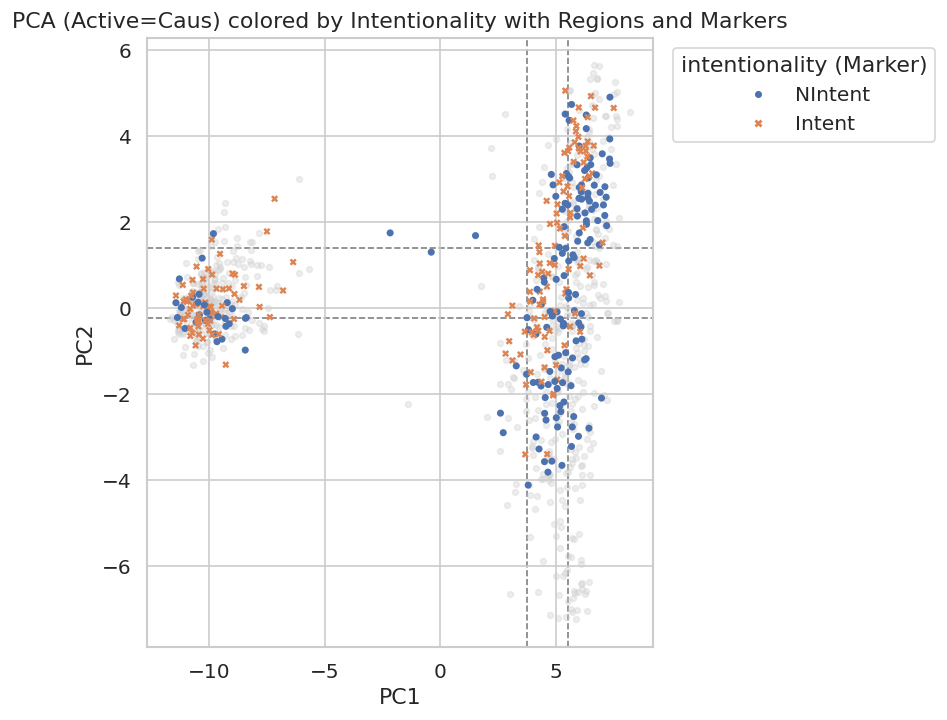

[PCA (Active=Caus) colored by Identifiability with Regions and Markers] counts per level: {'Spec': 319, 'RC': 9}


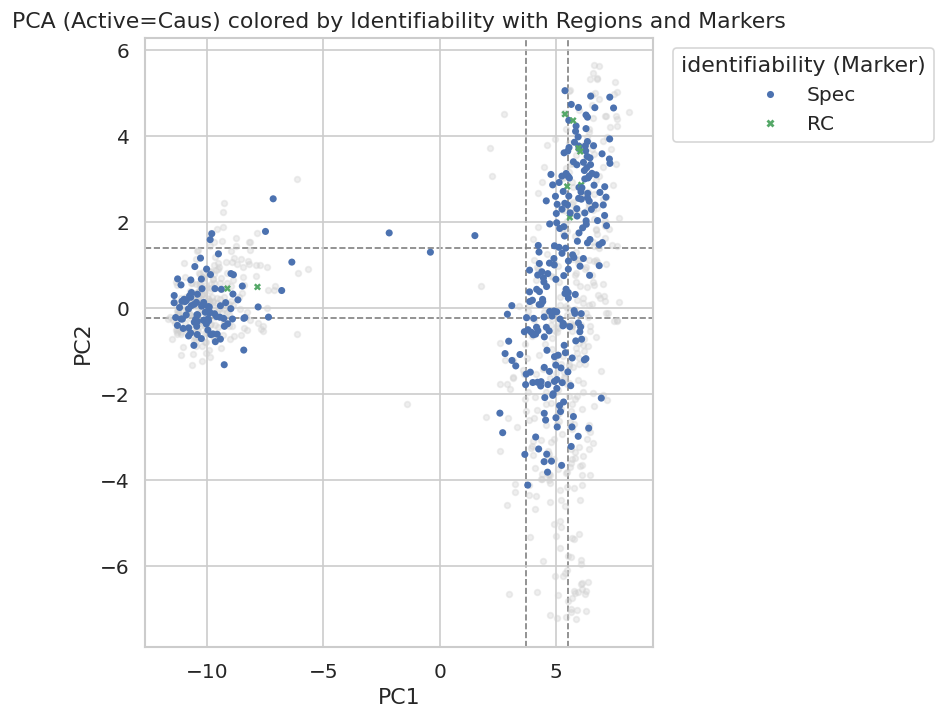

[PCA (Active=NCaus) colored by Intentionality with Regions and Markers] counts per level: {'NIntent': 499, 'Intent': 109}


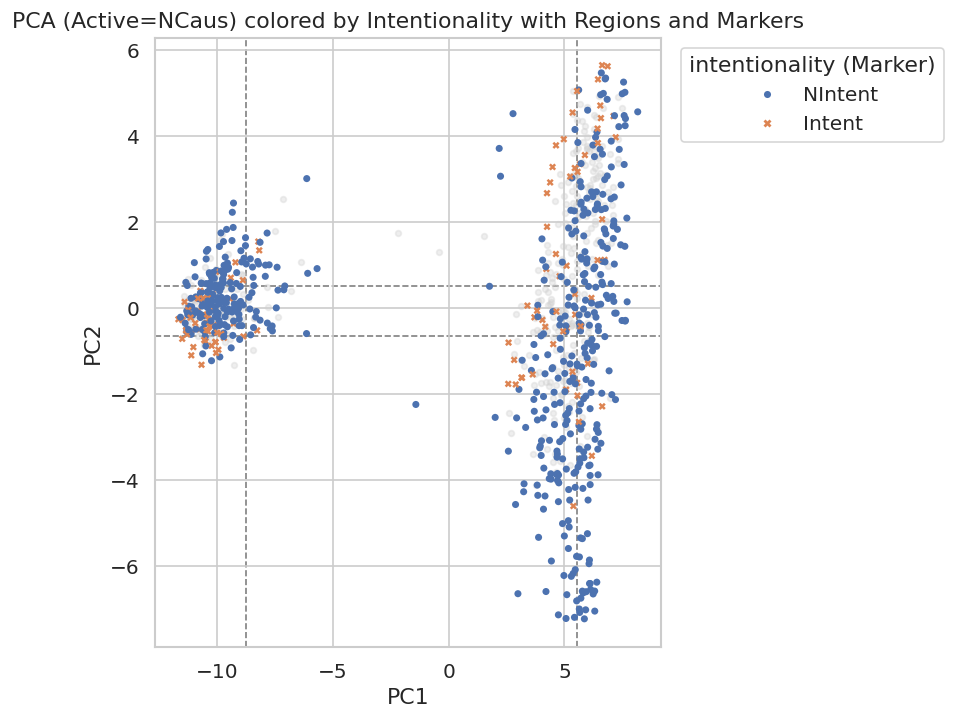

[PCA (Active=NCaus) colored by Identifiability with Regions and Markers] counts per level: {'RC': 424, 'UC': 115, 'Spec': 69}


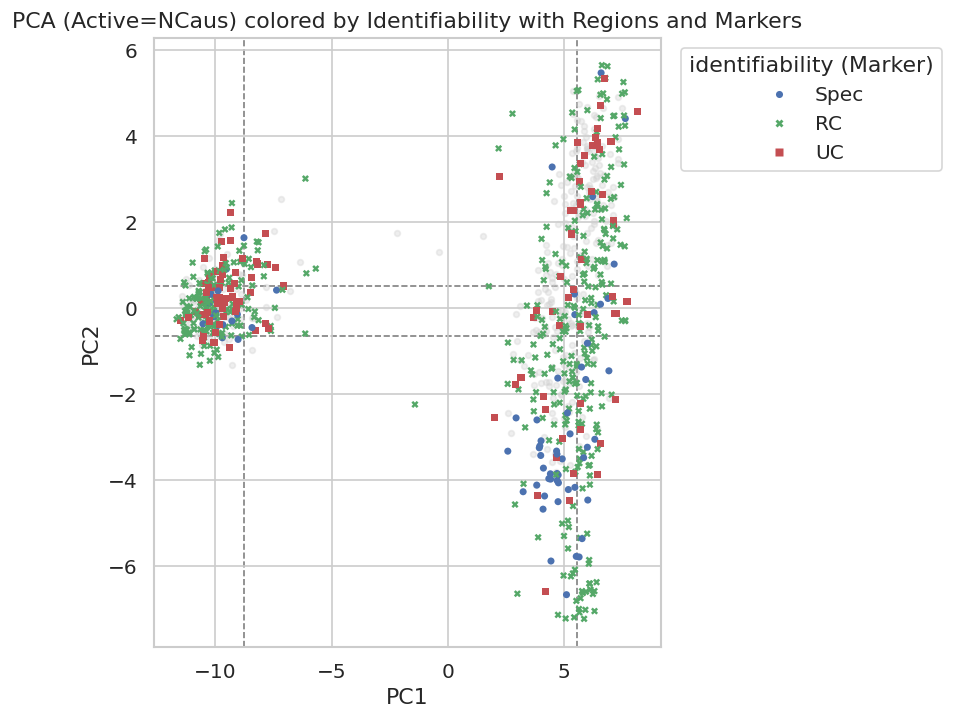

In [ ]:
# Define boolean masks (reusing from previous steps)
mask_caus = (df["syntax"] == "Caus")
mask_nc   = (df["syntax"] == "NCaus")

# Define color palettes (re-using existing palettes)
palette_int = {"NIntent": "#4C72B0", "Intent": "#DD8452"}            # 파랑/오렌지
palette_id  = {"Spec": "#4C72B0", "RC": "#55A868", "UC": "#C44E52"}  # 파랑/초록/빨강

# Define marker styles (re-using existing markers)
markers_int = {"NIntent": "o", "Intent": "X"}
markers_id  = {"Spec": "o", "RC": "X", "UC": "s"}


# Define PC1 and PC2 region thresholds (re-using previously calculated values)
# Causative
pc1_caus_thresholds = (pc1_caus_left_thresh, pc1_caus_right_thresh) if 'pc1_caus_left_thresh' in locals() else None
pc2_caus_thresholds = (pc2_caus_bottom_thresh, pc2_caus_top_thresh) if 'pc2_caus_bottom_thresh' in locals() else None

# Non-Causative
pc1_nc_thresholds = (pc1_nc_left_thresh, pc1_nc_right_thresh) if 'pc1_nc_left_thresh' in locals() else None
pc2_nc_thresholds = (pc2_nc_bottom_thresh, pc2_nc_top_thresh) if 'pc2_nc_bottom_thresh' in locals() else None


# Generate the four PCA scatter plots with region boundaries and different markers

# (1) Caus Active + Intentionality (with region boundaries and markers)
plot_active_inactive_fixed(
    df,
    active_mask=mask_caus,
    color_col="intentionality",
    title="PCA (Active=Caus) colored by Intentionality with Regions and Markers",
    palette=palette_int,
    hue_order=["NIntent", "Intent"],
    n_std=2.5,
    pc1_thresholds=pc1_caus_thresholds,
    pc2_thresholds=pc2_caus_thresholds,
    marker_col="intentionality", # Use intentionality for markers
    markers=markers_int         # Pass intentionality marker mapping
)

# (2) Caus Active + Identifiability (with region boundaries and markers)
plot_active_inactive_fixed(
    df,
    active_mask=mask_caus,
    color_col="identifiability",
    title="PCA (Active=Caus) colored by Identifiability with Regions and Markers",
    palette=palette_id,
    hue_order=["Spec", "RC", "UC"], # Ensure all Identifiability levels are in hue_order
    n_std=2.5,
    pc1_thresholds=pc1_caus_thresholds,
    pc2_thresholds=pc2_caus_thresholds,
    marker_col="identifiability", # Use identifiability for markers
    markers=markers_id         # Pass identifiability marker mapping
)

# (3) NCaus Active + Intentionality (with region boundaries and markers)
plot_active_inactive_fixed(
    df,
    active_mask=mask_nc,
    color_col="intentionality",
    title="PCA (Active=NCaus) colored by Intentionality with Regions and Markers",
    palette=palette_int,
    hue_order=["NIntent", "Intent"],
    n_std=2.5,
    pc1_thresholds=pc1_nc_thresholds,
    pc2_thresholds=pc2_nc_thresholds,
    marker_col="intentionality", # Use intentionality for markers
    markers=markers_int         # Pass intentionality marker mapping
)

# (4) NCaus Active + Identifiability (with region boundaries and markers)
plot_active_inactive_fixed(
    df,
    active_mask=mask_nc,
    color_col="identifiability",
    title="PCA (Active=NCaus) colored by Identifiability with Regions and Markers",
    palette=palette_id,
    hue_order=["Spec", "RC", "UC"], # Ensure all Identifiability levels are in hue_order
    n_std=2.5,
    pc1_thresholds=pc1_nc_thresholds,
    pc2_thresholds=pc2_nc_thresholds,
    marker_col="identifiability", # Use identifiability for markers
    markers=markers_id         # Pass identifiability marker mapping
)

[PCA (Active=Caus) colored by Intentionality with Markers] counts per level: {'Intent': 165, 'NIntent': 163}


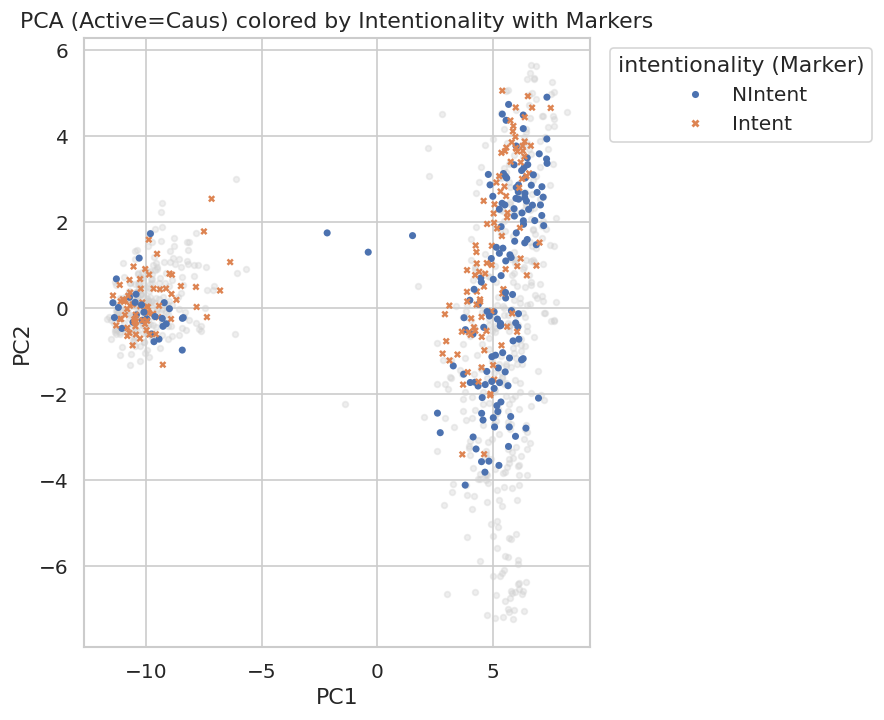

[PCA (Active=Caus) colored by Identifiability with Markers] counts per level: {'Spec': 319, 'RC': 9}


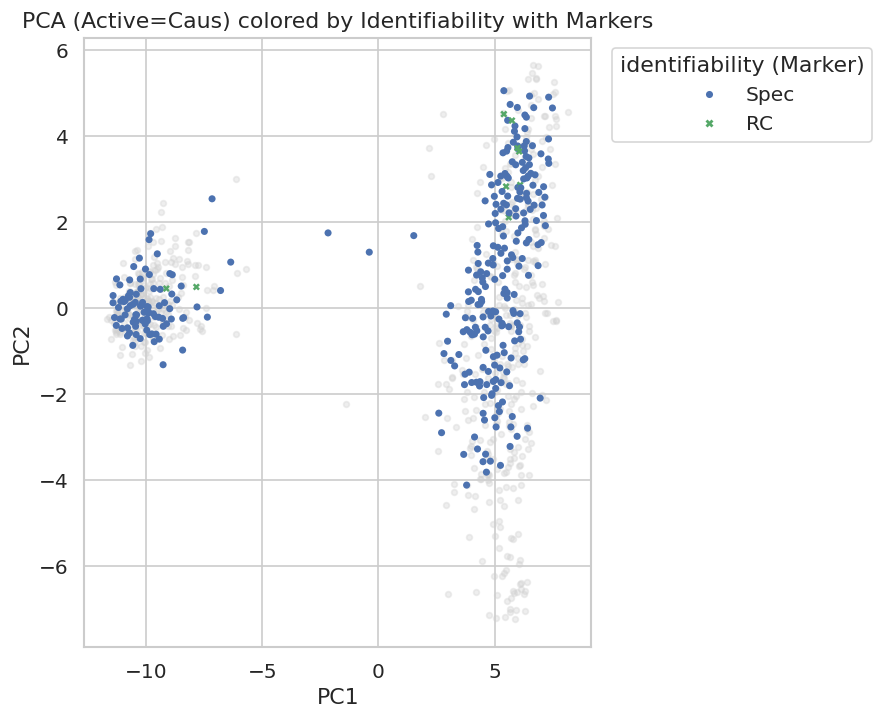

[PCA (Active=NCaus) colored by Intentionality with Markers] counts per level: {'NIntent': 499, 'Intent': 109}


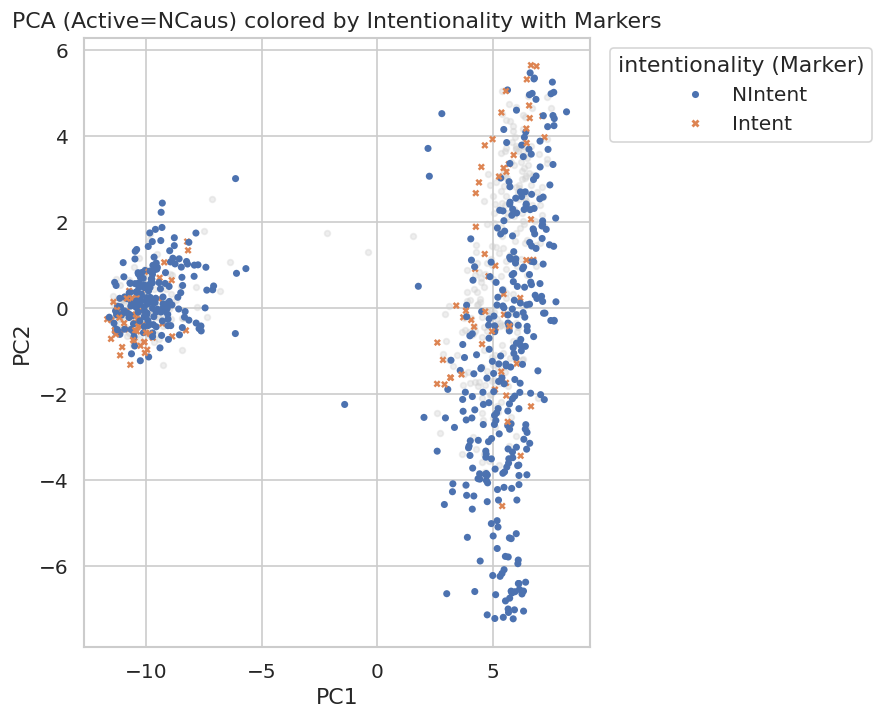

[PCA (Active=NCaus) colored by Identifiability with Markers] counts per level: {'RC': 424, 'UC': 115, 'Spec': 69}


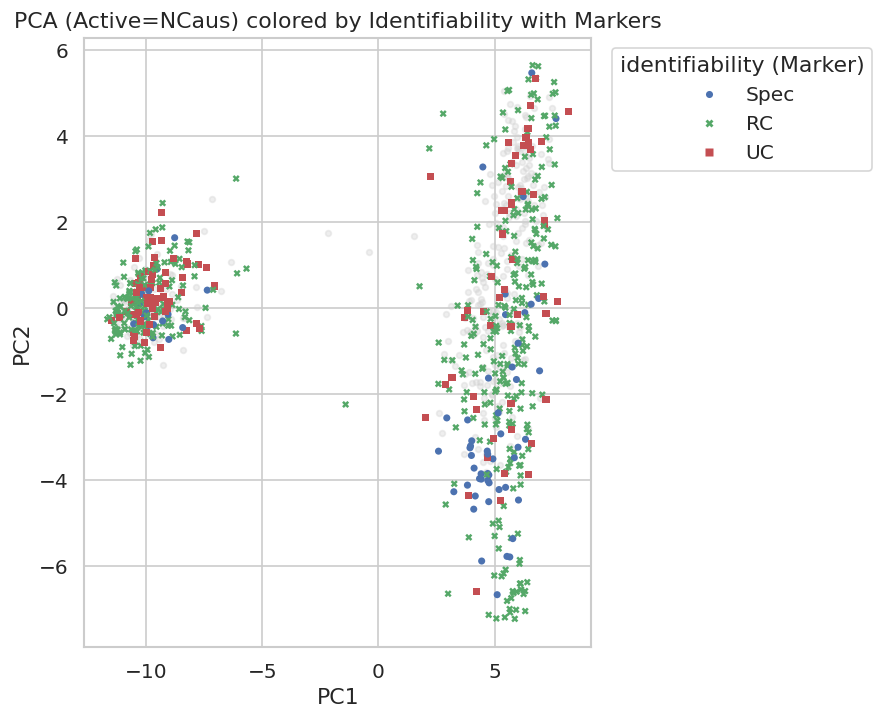

In [ ]:
# Generate the four PCA scatter plots WITHOUT region boundaries, with different markers

# (5) Caus Active + Intentionality (without region boundaries, with markers)
plot_active_inactive_fixed(
    df,
    active_mask=mask_caus,
    color_col="intentionality",
    title="PCA (Active=Caus) colored by Intentionality with Markers",
    palette=palette_int,
    hue_order=["NIntent", "Intent"],
    n_std=2.5,
    marker_col="intentionality", # Use intentionality for markers
    markers=markers_int         # Pass intentionality marker mapping
)

# (6) Caus Active + Identifiability (without region boundaries, with markers)
plot_active_inactive_fixed(
    df,
    active_mask=mask_caus,
    color_col="identifiability",
    title="PCA (Active=Caus) colored by Identifiability with Markers",
    palette=palette_id,
    hue_order=["Spec", "RC", "UC"], # Ensure all Identifiability levels are in hue_order
    n_std=2.5,
    marker_col="identifiability", # Use identifiability for markers
    markers=markers_id         # Pass identifiability marker mapping
)

# (7) NCaus Active + Intentionality (without region boundaries, with markers)
plot_active_inactive_fixed(
    df,
    active_mask=mask_nc,
    color_col="intentionality",
    title="PCA (Active=NCaus) colored by Intentionality with Markers",
    palette=palette_int,
    hue_order=["NIntent", "Intent"],
    n_std=2.5,
    marker_col="intentionality", # Use intentionality for markers
    markers=markers_int         # Pass intentionality marker mapping
)

# (8) NCaus Active + Identifiability (without region boundaries, with markers)
plot_active_inactive_fixed(
    df,
    active_mask=mask_nc,
    color_col="identifiability",
    title="PCA (Active=NCaus) colored by Identifiability with Markers",
    palette=palette_id,
    hue_order=["Spec", "RC", "UC"], # Ensure all Identifiability levels are in hue_order
    n_std=2.5,
    marker_col="identifiability", # Use identifiability for markers
    markers=markers_id         # Pass identifiability marker mapping
)